# Test methods for accessing CESM1 and CMIP6 output via Pangeo methodologies
## February 2024


### Step: 1 read in packages

In [1]:

# Packages needed generally
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs

Example 1: CESM1 Large Ensemble

Here I will demonstrate how to extract information from the CESM1 Large Ensemble hosted on Amazon Web Services, following similar steps as

https://github.com/dianaxnav/cesm-lens-aws-dn/tree/main

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files.

Things to note:

    The grid file used here is only for OCEAN variables; the atmosphere and land have different lat and lon information.
    For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".



### STEP 2: open catalog and find location of file

In [2]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"


The name of the ocean temperature variable is "TEMP"; a full list of CESM-specific variable names can be found here:

https://www.cesm.ucar.edu/community-projects/lens2/output-variables


### STEP 3: filter for just SST which is sea surface temp

In [22]:
# Search for the SST variable, display the first few entries in the resulting data frame
col.search(variable="SST").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
1,SST,potential temperature,ocn,CTRL,monthly,1.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-SS...
2,SST,potential temperature,ocn,HIST,monthly,1.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-SS...
3,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...


In [23]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members)
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="SST",
    experiment=["20C", "RCP85"],  
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
1,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...


## STEP 4: Load catalog entries

In [24]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])


### STEP 5 get file containing lat/lot grid info

In [6]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)

### STEP 6 subset for sets we are interested in

In [7]:
# Define Xarray datasets corresponding to the three experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]

In [8]:
#see what in this xarray
ds_20C

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 1, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 300, 1, 384, 320), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    NCO:                               4.4.4
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

### STEP 7 do this step

In [9]:
#for 1920 to 2000
ds_20C_mean=ds_20C.mean(dim="member_id")

In [10]:
#see what is in this x array
ds_20C_mean

<xarray.Dataset>
Dimensions:     (time: 1032, z_t: 1, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (time, z_t, nlat, nlon) float32 dask.array<chunksize=(300, 1, 384, 320), meta=np.ndarray>

### STEP 8 slice for 1950 to 2000

In [11]:
#slice for times between 1950 to 2000
test = ds_20C_mean.SST.sel(time=slice("1950", "2000"))
test

<xarray.DataArray 'SST' (time: 612, z_t: 1, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(612, 1, 384, 320), dtype=float32, chunksize=(300, 1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
  * z_t      (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon

### STEP 9 slice for just 1950

In [12]:
#slice for just 1950-03
test_1950 = test.sel(time='1950-03')
test_1950

<xarray.DataArray 'SST' (time: 1, z_t: 1, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(1, 1, 384, 320), dtype=float32, chunksize=(1, 1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1950-03-16 12:00:00
  * z_t      (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon

In [13]:
# define the extent of the map
#lonW = -140
#lonE = -40
#latS = 15
#latN = 65
#cLat = (latN + latS) / 2
#cLon = (lonW + lonE) / 2
#res = '110m'

In [14]:
# what does sea surface temperature around the US look like? (i.e. where would you like to go swimming..)
# Create a plot
#fig, ax = plt.subplots(figsize=(30, 20), 
#                       subplot_kw={'projection': ccrs.PlateCarree()})
#ax.set_title('')
#ax.set_extent([lonW, lonE, latS, latN], crs = ccrs.PlateCarree())
#tdat = ax.pcolormesh(test.isel(z_t=0, time=10), cmap='RdYlBu_r')
#plt.colorbar(tdat, ax=ax, shrink=0.5, pad=0.1)
#plt.savefig('basics_plot_4.png', bbox_inches='tight')# uncomment this to save your figure

# subsetting to just channel islands

<Axes: >

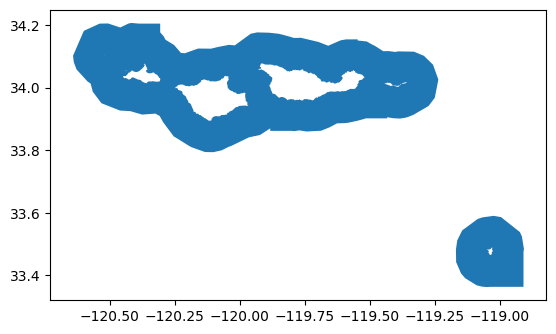

In [15]:
#import geopandas as gpd

# path to channel island shapefile
#cinms = 'cinms_py'

# Read the shapefile
#pts = gpd.read_file(cinms)

# Read the shapefile
#cinms_shape = gpd.read_file(cinms).to_crs(4326)

#cinms_shape.plot()

# Define the target projected CRS (e.g., WGS 84 / Pseudo-Mercator)
#target_crs = 'EPSG:3857'  # WGS 84 / Pseudo-Mercator EPSG code

# Reproject the geometries to the target CRS
#pts = pts.to_crs(target_crs)

#pts.plot()

### ignore:

In [16]:

#view contents of channel island geopanda dataframe
pts

,SANCTUARY,AREA_NAME,POLY_ID,DATUM,geometry
0,CINMS,Santa Barbara Section,2,NAD83,"POLYGON ((-119.03670 33.36320, -119.04812 33.3..."
1,CINMS,Northern Section,1,NAD83,"POLYGON ((-120.41801 34.20707, -120.38830 34.2..."


In [17]:
#find coordinates of channel islands
ch_coords = pts.get_coordinates()
ch_coords

,x,y
0,-119.036700,33.363200
0,-119.048120,33.362410
0,-119.068030,33.363750
0,-119.088910,33.368040
0,-119.132830,33.390590
...,...,...
1,-119.440309,34.012733
1,-119.439979,34.012733
1,-119.439605,34.012605
1,-119.438989,34.012211


In [18]:
# Add multiple columns using dictionary assignment
#adding back into pts dataframe
# creating new columns for lat and long
#new_data = {'x': ch_coords["x"], 'y': ch_coords["y"] }
#pts = pts.assign(**new_data)

#just add one into pts dataframe
#pts['x'] = ch_coords["x"]
#pts

In [19]:
import numpy as np
# Get the centroid of each geometry
#centroids = pts.geometry.centroid
#centroids
#here i want to extract shape file points and match them to the xarray dataset file I have in CMIP6
#lons = np.array(centroids.geometry.x.to_list())
#lats = np.array(centroids.geometry.y.to_list())
#lons

/tmp/ipykernel_359139/111858578.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = pts.geometry.centroid


array([-119.03258174, -119.96141916])

### STEP 10 subset to just channel islands

In [ ]:
import geopandas as gpd

# path to channel island shapefile
cinms = 'cinms_py'

# Read the shapefile
pts = gpd.read_file(cinms)

# Read the shapefile
cinms_shape = gpd.read_file(cinms).to_crs(4326)

cinms_shape.plot()

## Diana's stuff This is where I was able to get the map to render above are the steps that I took to get to this point

### STEP 11 get graph

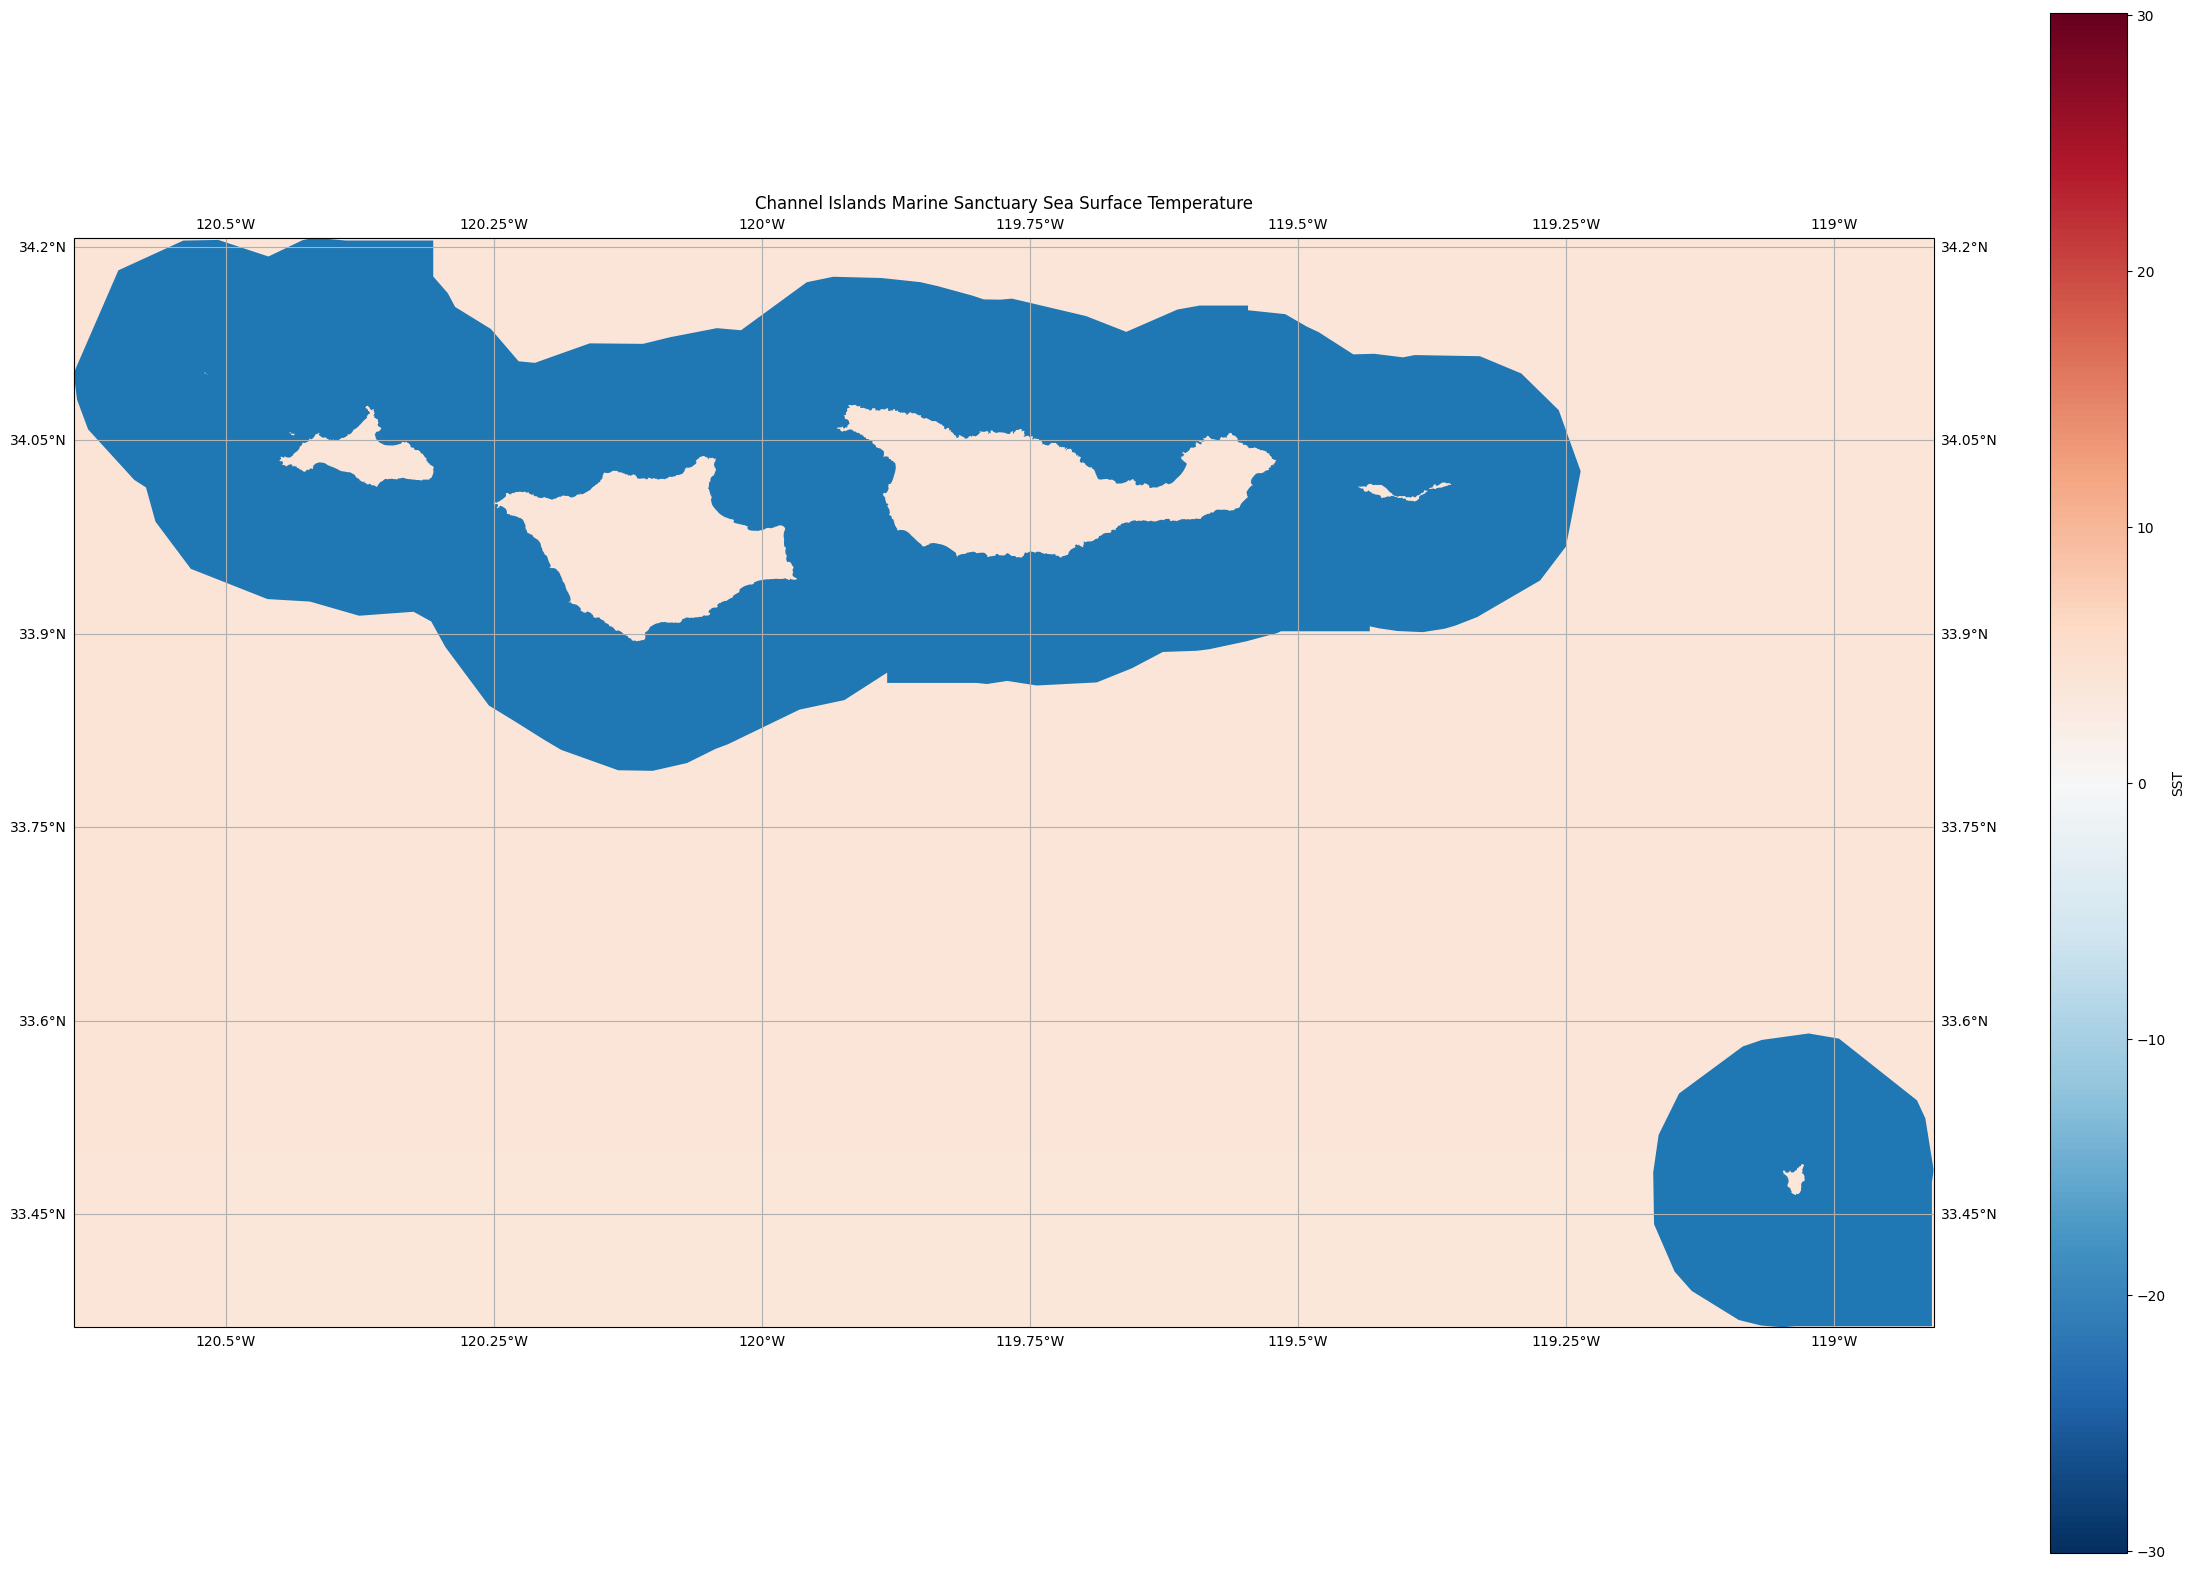

In [20]:
import cartopy.crs as ccrs

# Create a plot
fig, ax = plt.subplots(figsize=(30, 20), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the Xarray dataset as background
test_1950.plot(ax=ax, 
         transform=ccrs.PlateCarree())

# Set the extent of the plot based on the shapefile bounding box
ax.set_extent([cinms_shape.total_bounds[0], cinms_shape.total_bounds[2], cinms_shape.total_bounds[1], cinms_shape.total_bounds[3]])

# Plot the shapefile
cinms_shape.plot(ax=ax)

# Add gridlines
ax.gridlines(draw_labels=True)

# Add a title
ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature')

# Show the plot
plt.show()